<a href="https://colab.research.google.com/github/lenaphamthi/PTDL-HK1_2023-2024/blob/main/%C4%90%E1%BB%93%20%C3%A1n%20PTDL-M%C3%B4_h%C3%ACnh_LSTM_v%C3%A0_c%C3%A1c_thu%E1%BA%ADt_to%C3%A1n_t%E1%BB%91i_%C6%B0u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('all')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_gr

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#https://drive.google.com/file/d/1M_ihUXaTU5cGCE9HEVSB_ay4DQ-bKfrd/view?usp=drive_link
#https://drive.google.com/file/d/1uDUiSC2LvWJpPuXzWKP6M8z3vvthtsKO/view?usp=sharing
!gdown 1uDUiSC2LvWJpPuXzWKP6M8z3vvthtsKO
#!gdown 1M_ihUXaTU5cGCE9HEVSB_ay4DQ-bKfrd


In [ ]:
df = pd.read_csv('cleaned_df .csv')
df.head()

In [ ]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='Accent').generate(' '.join(df['clean']))

plt.imshow(wc)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df["clean"], df['label'], test_size=0.2)
vocab_size = 1000
embedding_dim = 300
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

In [ ]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=["Positive", "negative", 'neutral'])
visualizer.fit(y_train=y_test)
visualizer.poof()

In [ ]:
tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

In [ ]:
# Libraries to create and train our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import Callback

In [ ]:
# Model

model = Sequential()

model.add(Embedding(total_word + 1,embedding_dim,input_length = max_length))

model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          11348700  
                                                                 
 lstm (LSTM)                 (None, 200, 200)          400800    
                                                                 
 dropout (Dropout)           (None, 200, 200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
# Hàm callback để dừng huấn luyện khi đạt được độ chính xác mong muốn
class AccuracyCallback(Callback):
    def __init__(self, target_accuracy):
        super(AccuracyCallback, self).__init__()
        self.target_accuracy = target_accuracy
        self.start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.start_time is None:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy') or logs.get('val_acc')
        if current_accuracy >= self.target_accuracy:
            end_time = time.time()
            total_time = end_time - self.start_time
            print(f"Target accuracy reached! Total training time: {total_time:.2f} seconds")

# Khởi tạo callback với độ chính xác mục tiêu là 0.8 (80%)
accuracy_callback = AccuracyCallback(target_accuracy=0.8)

In [ ]:
from keras.callbacks import ModelCheckpoint
import time

In [ ]:
checkpoint = ModelCheckpoint('/content/model_adam-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only = True,
                                 mode='auto')

In [ ]:
start_time = time.time()
model.fit(train_padded, train_labels, epochs = 20, validation_data=(test_padded, test_labels),batch_size=64, callbacks=[checkpoint, accuracy_callback])
# Kết thúc tính thời gian
end_time = time.time()
# Tính tổng thời gian chạy huấn luyện
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 1.0465 - accuracy: 0.4084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 55s 173ms/step - loss: 1.0465 - accuracy: 0.4084 - val_loss: 1.0430 - val_accuracy: 0.4134
Epoch 2/20
275/275 [==============================] - 28s 102ms/step - loss: 1.0511 - accuracy: 0.4144 - val_loss: 1.0359 - val_accuracy: 0.4134
Epoch 3/20
275/275 [==============================] - 19s 69ms/step - loss: 1.0366 - accuracy: 0.4170 - val_loss: 1.0347 - val_accuracy: 0.4255
Epoch 4/20
275/275 [==============================] - 17s 63ms/step - loss: 0.9518 - accuracy: 0.5434 - val_loss: 0.9134 - val_accuracy: 0.5875
Epoch 5/20
275/275 [==============================] - 15s 55ms/step - loss: 0.7912 - accuracy: 0.6687 - val_loss: 0.7022 - val_accuracy: 0.6884
Epoch 6/20
275/275 [==============================] - 14s 50ms/step - loss: 0.5774 - accuracy: 0.7666 - val_loss: 0.5611 - val_accuracy: 0.7757
Epoch 7/20
275/275 [==============================] - 13s 47ms/step - loss: 0.4441 - accuracy: 0.8240 - val_loss: 0.5065 - val_accuracy: 0.7943
E

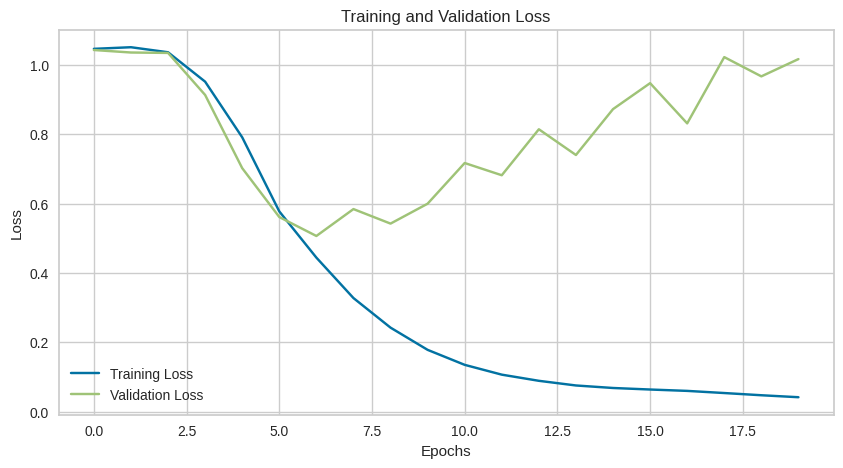

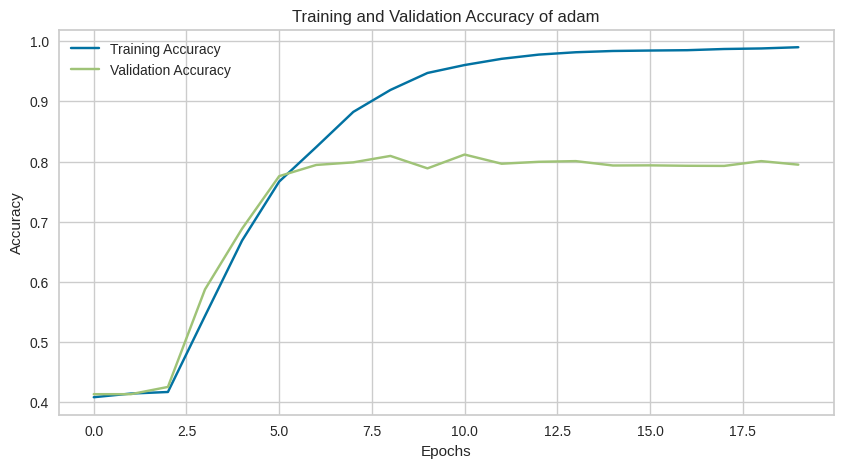

In [ ]:
import matplotlib.pyplot as plt



# Lấy giá trị mất mát và accuracy từ history
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy of adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.optimizers import Adam

#khai báo adamW
# Sử dụng optimizer AdamW từ TensorFlow
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)

# Model

model = Sequential()

model.add(Embedding(total_word + 1,embedding_dim,input_length = max_length))

model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer= optimizer,metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('/content/model_adamW-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only = True,
                                 mode='auto')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 300)          11348700  
                                                                 
 lstm_4 (LSTM)               (None, 200, 200)          400800    
                                                                 
 dropout_6 (Dropout)         (None, 200, 200)          0         
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               51456     
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [ ]:
start_time = time.time()
model.fit(train_padded, train_labels, epochs = 20, validation_data=(test_padded, test_labels),batch_size=64, callbacks=[checkpoint, accuracy_callback])
# Kết thúc tính thời gian
end_time = time.time()
# Tính tổng thời gian chạy huấn luyện
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/20
275/275 [==============================] - 37s 115ms/step - loss: 1.0458 - accuracy: 0.4114 - val_loss: 1.0356 - val_accuracy: 0.4184
Epoch 2/20
275/275 [==============================] - 21s 78ms/step - loss: 1.0478 - accuracy: 0.4181 - val_loss: 1.0365 - val_accuracy: 0.4100
Epoch 3/20
275/275 [==============================] - 18s 64ms/step - loss: 1.0218 - accuracy: 0.4589 - val_loss: 1.0202 - val_accuracy: 0.4600
Epoch 4/20
275/275 [==============================] - 16s 57ms/step - loss: 1.0246 - accuracy: 0.4477 - val_loss: 1.0215 - val_accuracy: 0.4523
Epoch 5/20
275/275 [==============================] - 14s 52ms/step - loss: 1.0276 - accuracy: 0.4428 - val_loss: 1.0288 - val_accuracy: 0.4366
Epoch 6/20
275/275 [==============================] - 14s 51ms/step - loss: 1.0323 - accuracy: 0.4349 - val_loss: 1.0426 - val_accuracy: 0.4134
Epoch 7/20
275/275 [==============================] - 13s 48ms/step - loss: 1.0432 - accuracy: 0.4128 - val_loss: 1.0367 - val_accuracy

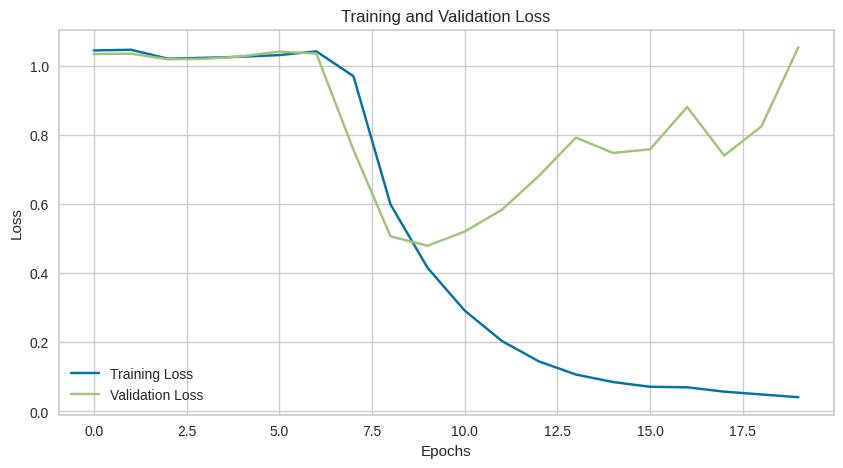

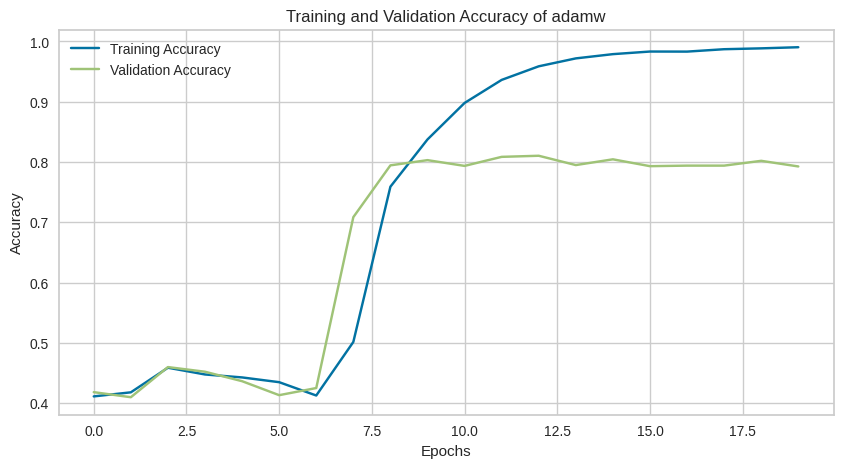

In [ ]:
import matplotlib.pyplot as plt



# Lấy giá trị mất mát và accuracy từ history
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy of adamw')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Model

model = Sequential()

model.add(Embedding(total_word + 1,embedding_dim,input_length = max_length))

model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('/content/model_sgd-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only = True,
                                 mode='auto')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 300)          11348700  
                                                                 
 lstm_6 (LSTM)               (None, 200, 200)          400800    
                                                                 
 dropout_9 (Dropout)         (None, 200, 200)          0         
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               51456     
                                                                 
 dropout_11 (Dropout)        (None, 256)              

In [ ]:
start_time = time.time()
model.fit(train_padded, train_labels, epochs = 20, validation_data=(test_padded, test_labels),batch_size=64, callbacks=[checkpoint, accuracy_callback])
# Kết thúc tính thời gian
end_time = time.time()
# Tính tổng thời gian chạy huấn luyện
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/20
275/275 [==============================] - 32s 105ms/step - loss: 1.0555 - accuracy: 0.4061 - val_loss: 1.0391 - val_accuracy: 0.4086
Epoch 2/20
275/275 [==============================] - 18s 67ms/step - loss: 1.0425 - accuracy: 0.4059 - val_loss: 1.0385 - val_accuracy: 0.4086
Epoch 3/20
275/275 [==============================] - 18s 65ms/step - loss: 1.0427 - accuracy: 0.4137 - val_loss: 1.0383 - val_accuracy: 0.4134
Epoch 4/20
275/275 [==============================] - 20s 74ms/step - loss: 1.0422 - accuracy: 0.4111 - val_loss: 1.0383 - val_accuracy: 0.4175
Epoch 5/20
275/275 [==============================] - 15s 53ms/step - loss: 1.0422 - accuracy: 0.4166 - val_loss: 1.0382 - val_accuracy: 0.4189
Epoch 6/20
275/275 [==============================] - 13s 46ms/step - loss: 1.0421 - accuracy: 0.4112 - val_loss: 1.0381 - val_accuracy: 0.4134
Epoch 7/20
275/275 [==============================] - 13s 46ms/step - loss: 1.0420 - accuracy: 0.4113 - val_loss: 1.0381 - val_accuracy

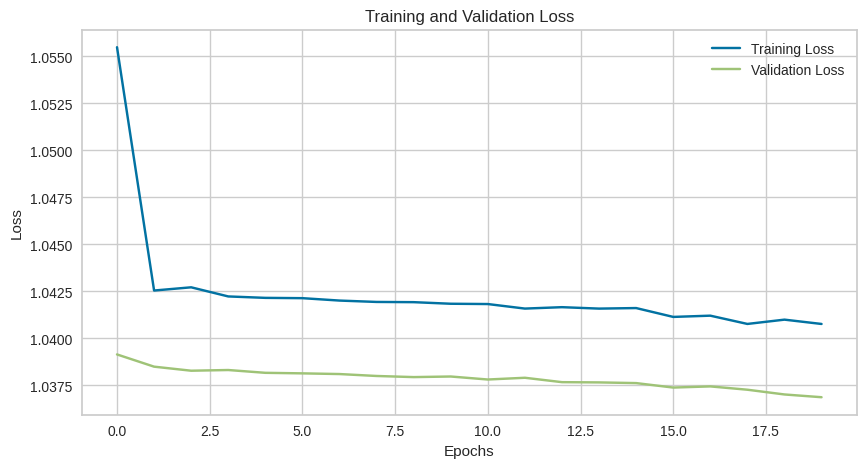

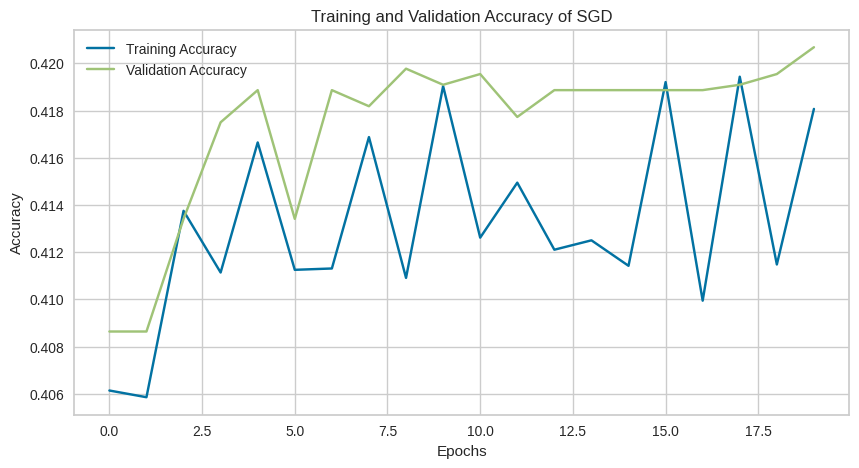

In [ ]:
# Lấy giá trị mất mát và accuracy từ history
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy of SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def load_model_(model_path):

  # Tải mô hình từ file
  loaded_model = load_model(model_path)

  # In thông tin về mô hình
  loaded_model.summary()
  return loaded_model

def process_data(data):
  tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')

  tokenizer.fit_on_texts(X_train)
  # print(tokenizer.word_index)
  total_word = len(tokenizer.word_index)
  print('Total distinct words: {}'.format(total_word))

  train_seq = tokenizer.texts_to_sequences(data)
  train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  return train_padded

def cleaning(text):
  #remove punctuations and uppercase
  clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

  #remove stopwords
  clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

  #lemmatize the word (normalization)
  sentence = []
  for word in clean_text:
      lemmatizer = WordNetLemmatizer()
      sentence.append(lemmatizer.lemmatize(word, 'v'))

  return ' '.join(sentence)


def truc_quan_kq(y_test, y_pred_knn):
  conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_knn)
  #sử dụng Matplotlib để vẽ confusion matrix
  fig, ax = plt.subplots(figsize=(5, 5))
  cax = ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  fig.colorbar(cax)
  plt.xlabel('Dự đoán', fontsize=18)
  plt.ylabel('Label', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

In [ ]:
lstm_adam = load_model_('/content/model_adam-007.h5')
lstm_sgd = load_model_('/content/model_sgd-020.h5')
lstm_adamw = load_model_('/content/model_adamW-010.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          11348700  
                                                                 
 lstm (LSTM)                 (None, 200, 200)          400800    
                                                                 
 dropout (Dropout)           (None, 200, 200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

138/138 [==============================] - 1s 9ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


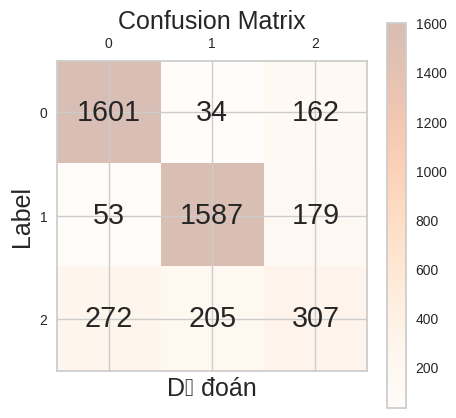

Accuracy : 79.43%


In [ ]:
from numpy import argmax

pre_adam = lstm_adam.predict(test_padded)
predictions = argmax(pre_adam, axis=1)
testY = argmax(test_labels, axis=1)
truc_quan_kq(testY, predictions)
accuracy = accuracy_score(testY, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

In [ ]:
print(classification_report(testY, predictions, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.83      0.89      0.86      1797
    Negative       0.87      0.87      0.87      1819
     Neutral       0.47      0.39      0.43       784

    accuracy                           0.79      4400
   macro avg       0.72      0.72      0.72      4400
weighted avg       0.78      0.79      0.79      4400



138/138 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


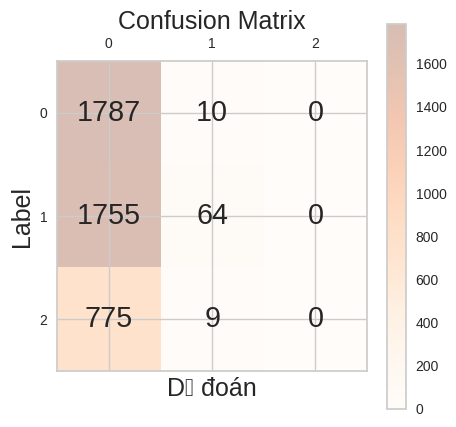

Accuracy : 42.07%


In [ ]:
pre_sgd = lstm_sgd.predict(test_padded)
predictions = argmax(pre_sgd, axis=1)
testY = argmax(test_labels, axis=1)
truc_quan_kq(testY, predictions)
accuracy = accuracy_score(testY, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

In [ ]:
print(classification_report(testY, predictions, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.41      0.99      0.58      1797
    Negative       0.77      0.04      0.07      1819
     Neutral       0.00      0.00      0.00       784

    accuracy                           0.42      4400
   macro avg       0.40      0.34      0.22      4400
weighted avg       0.49      0.42      0.27      4400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


138/138 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


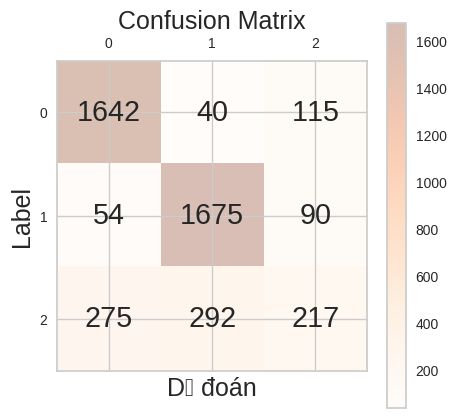

Accuracy : 80.32%


In [ ]:
pre_adamw = lstm_adamw.predict(test_padded)
predictions = argmax(pre_adamw, axis=1)
testY = argmax(test_labels, axis=1)
truc_quan_kq(testY, predictions)
accuracy = accuracy_score(testY, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

In [ ]:
print(classification_report(testY, predictions, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.83      0.91      0.87      1797
    Negative       0.83      0.92      0.88      1819
     Neutral       0.51      0.28      0.36       784

    accuracy                           0.80      4400
   macro avg       0.73      0.70      0.70      4400
weighted avg       0.78      0.80      0.78      4400



In [ ]:
label = ['Positive', 'Negative', 'Neutral']

In [ ]:
data = 'Po Nagar Cham Tower is a Cham temple tower founded sometime before 781 C.E. and located in the medieval principality of Kauthara, near modern Nha Trang in Vietnam. It is dedicated to Yan Po Nagar, the goddess of the country, who came to be identified with the Hindu goddesses Bhagavati and Mahishasuramardini, and who in Vietnamese is called Thi\xEAn Y Th\xE1nh M\u1EABuThe Cham ruled Vietnam for 10 centuries, the unmistakable architecture and art style had spread widely across places in the country. They are said to have their root in the India\u2019s Buddhism. Thus, there are a great deal of similarity between Angkor Wat and the Po Nagar Towers found in Nha Trang' #@param {type:"string"}
data_clean = cleaning(data)
data_processed = process_data(data_clean)
pre_adam = lstm_adam.predict(data_processed)
predictions = argmax(pre_adam, axis=1)
print(label[predictions[0]])


Total distinct words: 37828
15/15 [==============================] - 0s 17ms/step
Positive


In [ ]:
data = 'This place is very touristic, may go again' #@param {type:"string"}
data_clean = cleaning(data)
data_processed = process_data(data_clean)
pre_adam = lstm_adamw.predict(data_processed)
predictions = argmax(pre_adam, axis=1)
print(label[predictions[0]])

Total distinct words: 37828
1/1 [==============================] - 0s 81ms/step
Neutral
